# A Cognitive Model or Harmonic Types (Simplified Amortization)

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Thesis/probabilistic_harmony_model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Thesis/probabilistic_harmony_model


In [2]:
!pip install pyro-api==0.1.2
!pip install pyro-ppl==1.8.4
!pip install pitchtypes==0.4.0

In [3]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from pyro.distributions import *
#from collections import Counter
import pyro.infer
import pyro.optim
import pyro.util
pyro.enable_validation(True)

import matplotlib.pyplot as plt
import tqdm

import numpy as np
import pandas as pd
import scipy.stats as stats

import os.path as path
from datetime import datetime
import json

import utils

import gc

In [4]:
gpu = torch.cuda.is_available()
gpu_n = 0
torch.set_default_dtype(torch.float64)
device = torch.device(f'cuda:{gpu_n}' if gpu else 'cpu')
torch.set_default_device(device)
print(device)

cpu


In [5]:
def save_rng_state(name):
    fn = name + '-' + datetime.today().isoformat() + '.state'
    state = pyro.util.get_rng_state()
    with open('rng-' + fn, 'w') as f:
        print(state, file=f)
    torch.save(state['torch'], 'torch-' + fn)

In [6]:
# set random seeds
pyro.set_rng_seed(0)
#torch.set_deterministic(True)
#torch.set_num_threads(1)
#torch.set_num_interop_threads(1)

# fix the range of pitches we consider
fifth_range = 2*7                  # 2 diatonics
npcs = 2*fifth_range+1             # around C: Cbb to C## on LoF
utils.set_fifth_range(fifth_range) # used to make helper functions work correctly

# **1. Amortization**



## Step 1: Model

**Notations:**
- $h$: probablity distribution of chords (harmony)
- $\Phi$: chord profile for all chord types, where each $\phi_i$ conntains weights for each chord
- $npcs$: range of line of fifths, which is the number of pitches we consider
- $n_{harmonies}$: number of different chord types
- $n_{chords}$: length of dataset (how many chords we observe in the dataset)

**Generating Process:**

For all $i$:

- $\phi_i \sim Dirichlet(0.5, npcs)$
- $h \sim Dirichlet(0.5, n_{harmonies})$

    For each chord j:
    - Choose chords: $c_i \sim Categorical(h)$
    - Choose pitches: $p_j \sim Multinomial(\phi_{cj}, N_j)$

where $p_j$ and $N_j$ are observed, other variables are unobserved.

In [7]:
def simplified_chord_model(nharmonies, nchords, data):
  # parameters priors:
  # distribution of the harmonies
  p_harmony = pyro.sample('p_harmony', dist.Dirichlet(torch.ones(nharmonies, device=device)))

  # distribution of notes in the harmonies (chord profiles)
  with pyro.plate("harmonies", nharmonies):
    chord_profiles = pyro.sample("theta", dist.Dirichlet(torch.ones(npcs, device=device)))

  # Sampling the data:
  nchords = len(data['c'])
  with pyro.plate("chords", nchords) as ind:
    # sample a chord type based on the harmony distribution (to be inferred)
    # c = pyro.sample('c', dist.Categorical(p_harmony))
    # sample chord types from a uniform categorical distribution
    c = pyro.sample("c", dist.Categorical(torch.ones(nharmonies, device=device) / nharmonies))

    # sampling pitches for the chord based on the selected chord type profile
    pyro.sample("notes", dist.Multinomial(1, chord_profiles[c], validate_args=False), obs=data['pitches'][ind])

## Step 2: Amortization Guide for Inference


In [8]:
def normalize_notes(notes):
  scale = 1/torch.max(notes, dim=1).values
  return torch.mul(notes, scale.reshape(len(scale), 1))

In [9]:
class AmortizedChordGuide(nn.Module):
  # def __init__(self, nharmonies):
  #       super().__init__()
  #       hidden = 32
  #       self.f = nn.Sequential(
  #           nn.Linear(npcs, hidden),
  #           nn.ReLU(),
  #           nn.Linear(hidden, nharmonies),
  #           nn.Softmax(dim=-1)
  #       )

  # def forward(self, x):
  #       return self.f(normalize_notes(x))

  def __init__(self, nharmonies):
      super().__init__()
      hidden = 32
      self.f = nn.Sequential(
          nn.Linear(npcs, hidden),
          nn.SELU(),
          nn.Dropout(0.2),
          nn.Linear(hidden, nharmonies),
          nn.Softmax(dim=1)
      )

  def forward(self, notes):
      return self.f(normalize_notes(notes))

  def guide(self, nharmonies, nchords, data):
      pyro.module("chord_predictor", self)

      # for harmony distribution
      alpha_h = pyro.param('alpha_h', torch.ones(nharmonies, device=device), constraint=constraints.positive)
      pyro.sample('p_harmony', dist.Dirichlet(alpha_h))

      # for chord profiles
      alpha_phi = pyro.param("alpha_phi", torch.ones(nharmonies, npcs, device=device), constraint=constraints.positive)
      with pyro.plate("harmonies", nharmonies):
        pyro.sample("theta", dist.Dirichlet(alpha_phi))

      # for chords
      nchords = len(data['c'])
      subs = min(500, nchords)
      with pyro.plate("chords", nchords, subsample_size=subs) as ind:
        chord_type_params = self.forward(data['pitches'][ind])
        pyro.sample("c", dist.Categorical(chord_type_params))

      return alpha_phi, alpha_h

## Step 3: Data and Conditioning
**Data Format**


In [10]:
def simplified_chord_tensor(notes):
    """Takes a list of fifths and returns a vector of counts for fifths."""
    chord = torch.zeros(npcs, device=device)
    for fifth in notes:
        index = utils.fifth_to_index(fifth)
        chord[index] += 1
    return chord

def simplified_annot_data_obs(chords):
    """Helper function to turn a list of chord dictionaries into a dictionary of observation vectors."""
    obs = {}
    obs["pitches"] = torch.cat([simplified_chord_tensor(c['notes']).reshape((1, -1)) for c in chords], dim=0)
    obs["c"] = torch.tensor([c['label'] for c in chords], device=device)
    obs["n"] = torch.tensor([len(c['notes']) - 1 for c in chords], device=device)
    return obs

**Loading the Dataset**

The data is loaded from a TSV file that. The resulting dataframe is converted to the observation format that we pass to the model.

In [11]:
def load_dataset(filename):
    filename = path.join("data", filename)
    print("loading dataset...")
    df = utils.load_csv(filename)
    sizes = df.groupby(['chordid', 'label']).size()
    type_counts = sizes.groupby('label').size().sort_values(ascending=False)
    chordtypes = type_counts.index.tolist()
    df['numlabel'] = df.label.map(chordtypes.index)

    # check if precomputed tensor data is available:
    prefn = filename + "_precomp.pt"
    if path.exists(prefn) and path.getmtime(prefn) > path.getmtime(filename):
        print("using precomputed tensor data.")
        obs = torch.load(prefn, map_location=device)
    else:
        print('extracting chords...')
        chords = [{'label': numlabel, 'notes': [row['fifth'] for index, row in grp.iterrows()]}
                  for (_, numlabel), grp in tqdm.tqdm(df.groupby(['chordid', 'numlabel']))]
        print('converting chords to tensors...')
        obs = simplified_annot_data_obs(chords)
        torch.save(obs, prefn)

    print(len(chordtypes), "chord types")
    print(len(obs["c"]), "chords")
    return df, obs, chordtypes

After inferring the parameters we save them for easier inspection and reuse.



In [12]:
def save_params(params, nharmonies, npcs, name):
    # Save the PyTorch parameters
    torch.save(params , path.join("results", name + '.pt'))

    # Save the parameters in a JSON file for easy access
    with open(path.join("results", name + '.json'), 'w') as f:
        json.dump({'params': {key: val.tolist() for key, val in params.items()},
                   'nharmonies': nharmonies,
                   'npcs': npcs},
                  f)

## Step 4: Inference

**Initial Training with Uniform Prior:**

In the `simplified_chord_model`, chord types (`c`) are initially sampled from a uniform distribution: `dist.Categorical(torch.ones(nharmonies, device=device) / nharmonies)`. This setup ensures that the initial training phase does not assume any prior knowledge about the prevalence of different chord types.

**Transition to Learning Chord Prevalence:**

The function `infer_with_p_harmony` updates the model to incorporate learning the prevalence of chord types (`p_harmony`). In this updated model, chord types are sampled based on `p_harmony`: `dist.Categorical(p_harmony)`, which is learned from the data. This shift refines the model based on observed distributions after the initial exploration phase.

In [13]:
def infer_amortized_posteriors(nclusters, npcs, nharmonies, data, nsteps=5000, lr=0.005, step_size=100, plot_loss=True, save_as=None, collect_history=False):
    pyro.clear_param_store()
    pyro.set_rng_seed(1625)

    # create an instance of the guide
    amortized_guide = AmortizedChordGuide(nclusters).to(device)

    svi = pyro.infer.SVI(model=simplified_chord_model,
                         guide=amortized_guide.guide,
                         optim=pyro.optim.Adam({"lr": lr, "foreach": False}),
                         loss=pyro.infer.Trace_ELBO())

    losses = []
    alpha_phi_history = []

    for i in tqdm.tqdm(range(nsteps)):
        loss = svi.step(nclusters, len(data['c']), data)
        losses.append(loss)

        if collect_history:
            # collect parameter histories
            alpha_phi_history.append(pyro.param('alpha_phi').detach().cpu().numpy())

        # if step % 100 == 0:
        #     print(f"Step {step} : loss = {loss}")

    # plot the loss
    if plot_loss:
        plt.figure(figsize=(12, 5))
        plt.plot(losses)
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title(f"SVI Convergence ({save_as})")
        plt.show()

    # save inferred parameters
    params = {name: value.detach().cpu().numpy() for name, value in pyro.get_param_store().items()}

    if save_as is not None:
        save_params(params, nharmonies, npcs, save_as)

    return params, amortized_guide, alpha_phi_history if collect_history else params

In [14]:
def infer_with_p_harmony(nharmonies, npcs, data, trained_network, nsteps=5000, lr=0.005):
    def updated_model(nharmonies, nchords, data):
        p_harmony = pyro.sample('p_harmony', dist.Dirichlet(torch.ones(nharmonies, device=device)))

        with pyro.plate("harmonies", nharmonies):
            chord_profiles = pyro.sample("theta", dist.Dirichlet(torch.ones(npcs, device=device)))

        nchords = len(data['c'])
        with pyro.plate("chords", nchords) as ind:
            c = pyro.sample("c", dist.Categorical(p_harmony))
            pyro.sample("notes", dist.Multinomial(1, chord_profiles[c], validate_args=False), obs=data['pitches'][ind])

    pyro.clear_param_store()
    amortized_guide = trained_network

    svi = SVI(model=updated_model,
              guide=amortized_guide.guide,
              optim=Adam({"lr": lr}),
              loss=Trace_ELBO())

    losses = []
    for step in tqdm.tqdm(range(nsteps)):
        loss = svi.step(nharmonies, len(data['c']), data)
        losses.append(loss)

    # plot the loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.show()

    return {name: pyro.param(name).detach().cpu().numpy() for name in pyro.get_param_store().keys()}

## Step 5: Plotting

In [15]:
def plot_param_histories(alpha_phi_history):
    alpha_phi_mean_history = np.mean(alpha_phi_history, axis=-1)  # Compute the mean over pitch classes
    plt.figure(figsize=(12, 5))
    plt.plot(alpha_phi_mean_history)
    plt.title('Mean Alpha_phi parameter history')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Alpha_phi values')
    plt.show()

In [16]:
def plot_harmony_distribution(params, nharmonies, save_as=None):
    harmony_params = params['alpha_h']

    # create a bar chart for the harmony distribution
    plt.figure(figsize=(8, 4))
    plt.bar(np.arange(nharmonies), harmony_params)
    plt.title('Harmony Distribution')
    plt.xlabel('Chord Type Index')
    plt.ylabel('Probability')
    plt.xticks(np.arange(nharmonies))

    plt.tight_layout()
    if save_as:
        plt.savefig(f"{save_as}.png")
    plt.show()

In [17]:
def plot_chord_profiles(params, nharmonies, npcs, save_as=None):
    chord_profile_params = params['alpha_phi']

    fig, axs = plt.subplots(nharmonies, 1, figsize=(12, 3 * nharmonies), squeeze=False)

    # plot chord profile parameters for each harmony
    for i in range(nharmonies):
        # Normalize chord profile parameters for plotting
        chord_profile_normalized = chord_profile_params[i] / np.sum(chord_profile_params[i])
        axs[i, 0].bar(np.arange(npcs), chord_profile_normalized)
        axs[i, 0].set_title(f'Chord Profile for Harmony {i}')
        axs[i, 0].set_xlabel('Pitch Index')
        axs[i, 0].set_ylabel('Probability')

    plt.tight_layout()
    if save_as:
        plt.savefig(f"{save_as}.png")
    plt.show()

# **2. Experiment**

In [18]:
dcml_df, dcml_obs, dcml_chordtypes = load_dataset('dcml.tsv')

loading dataset...
using precomputed tensor data.
14 chord types
113771 chords


100%|██████████| 5000/5000 [01:34<00:00, 53.17it/s]


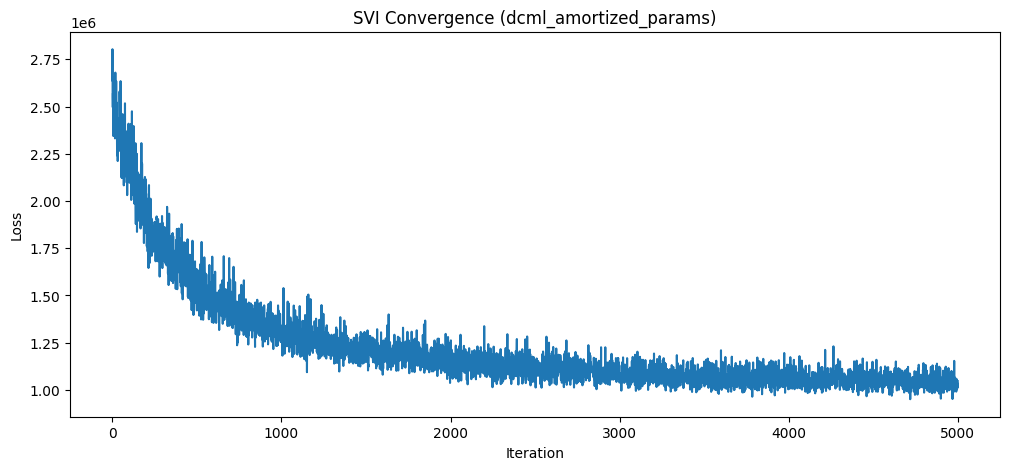

In [19]:
dcml_params, amortized_guide, alpha_phi_history = infer_amortized_posteriors(14, npcs, len(dcml_chordtypes), dcml_obs,
                                                                              nsteps=5000, lr=0.005, plot_loss=True,
                                                                              save_as="dcml_amortized_params", collect_history=True
                                                                              )

100%|██████████| 5000/5000 [01:33<00:00, 53.66it/s]


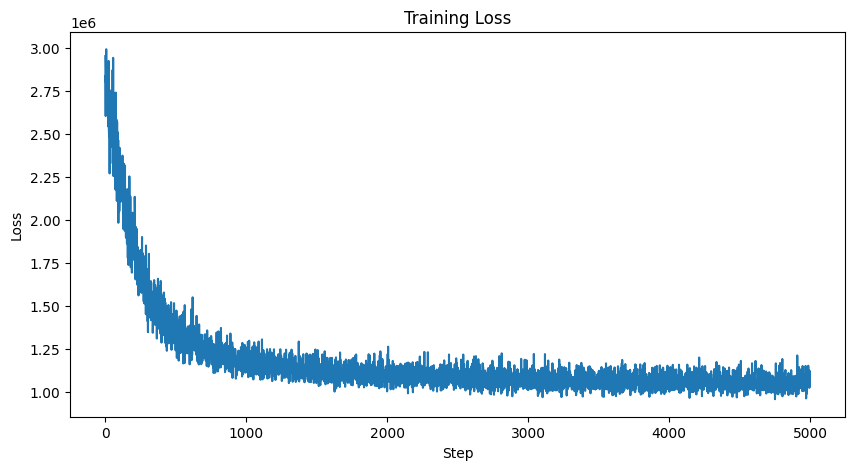

In [20]:
dcml_params_stage2 = infer_with_p_harmony(len(dcml_chordtypes), npcs, dcml_obs, amortized_guide, nsteps=5000, lr=0.005)

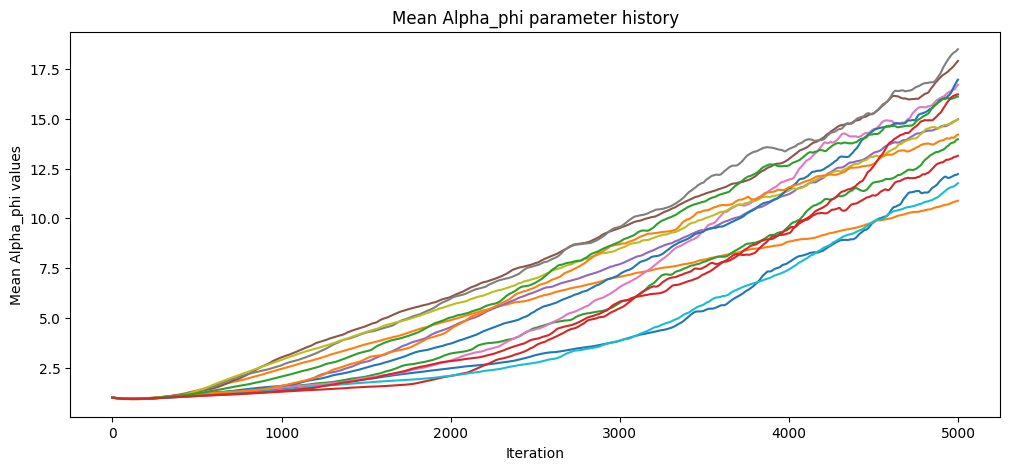

In [21]:
# Plot the parameter histories
plot_param_histories(alpha_phi_history)

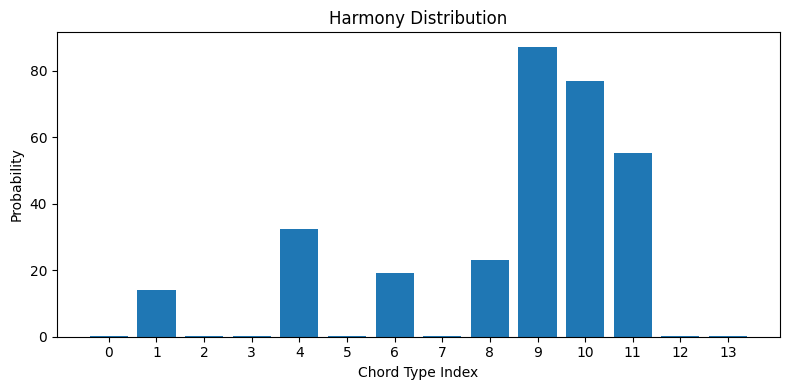

In [22]:
plot_harmony_distribution(dcml_params_stage2, len(dcml_chordtypes), save_as="dcml_harmony_distribution")

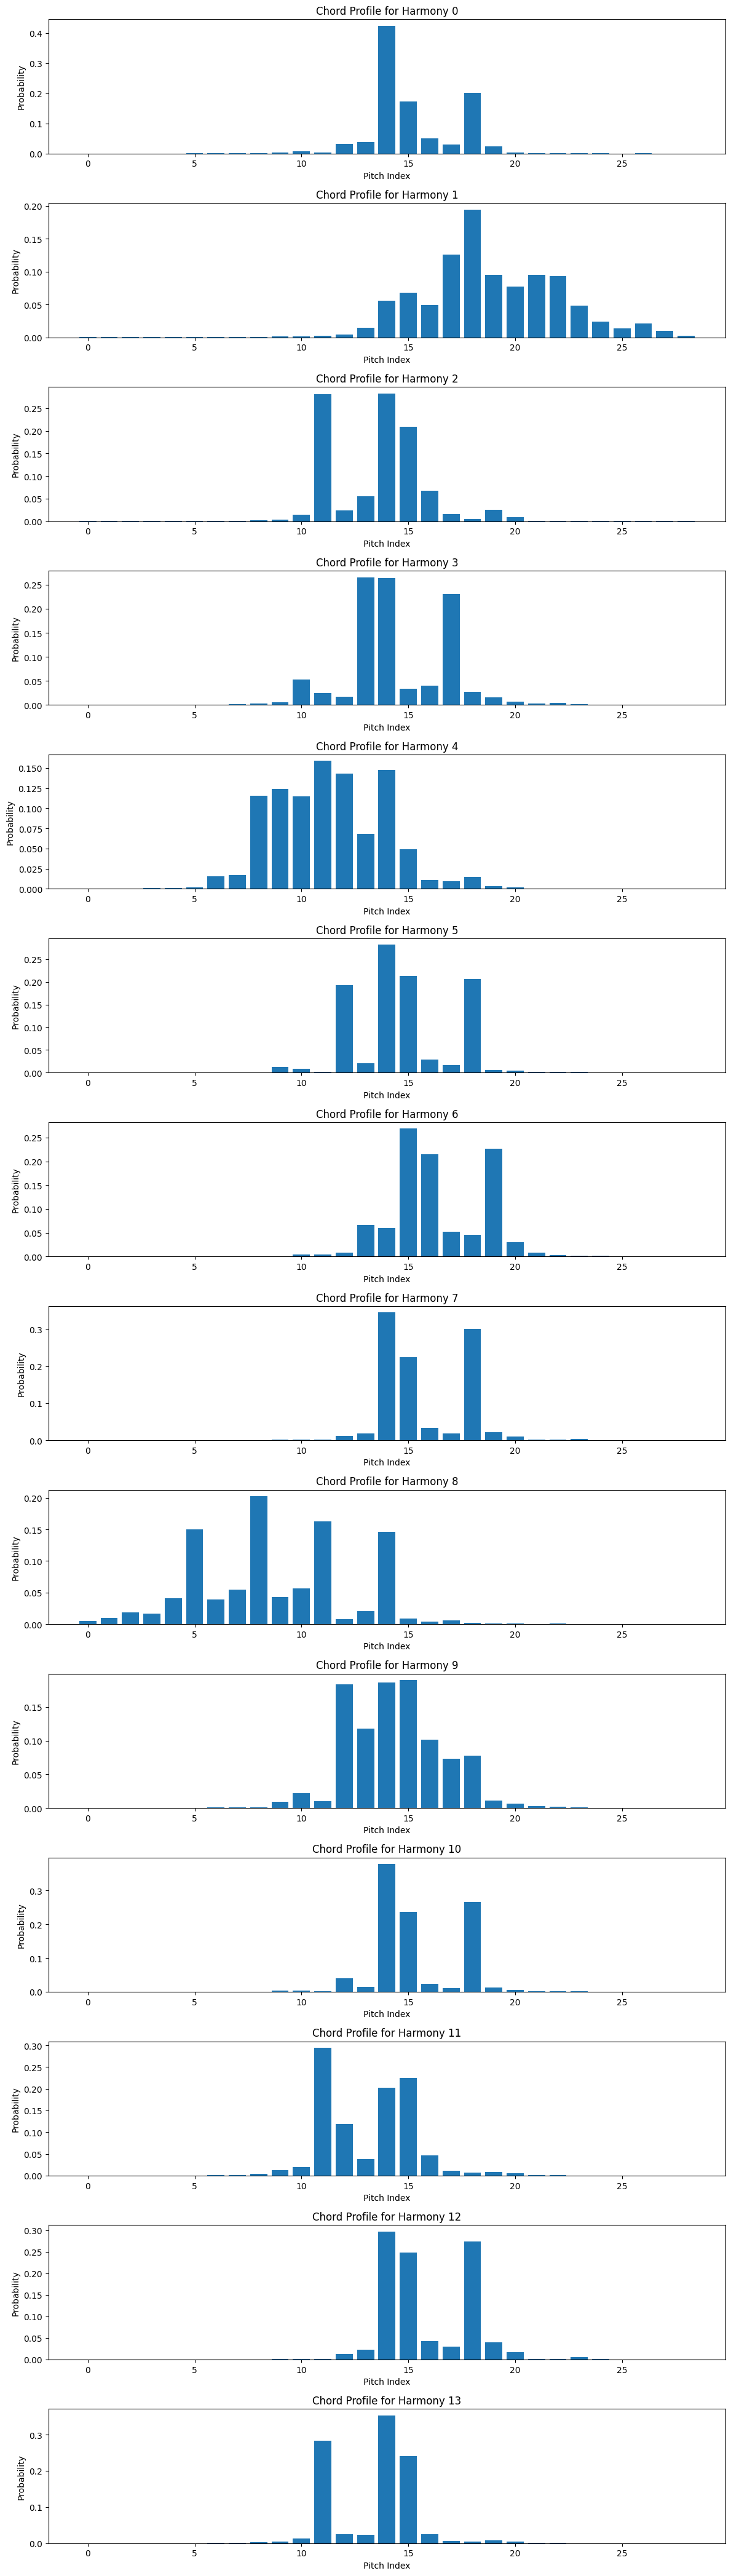

In [23]:
plot_chord_profiles(dcml_params, len(dcml_chordtypes), npcs, save_as="dcml_chord_profiles")

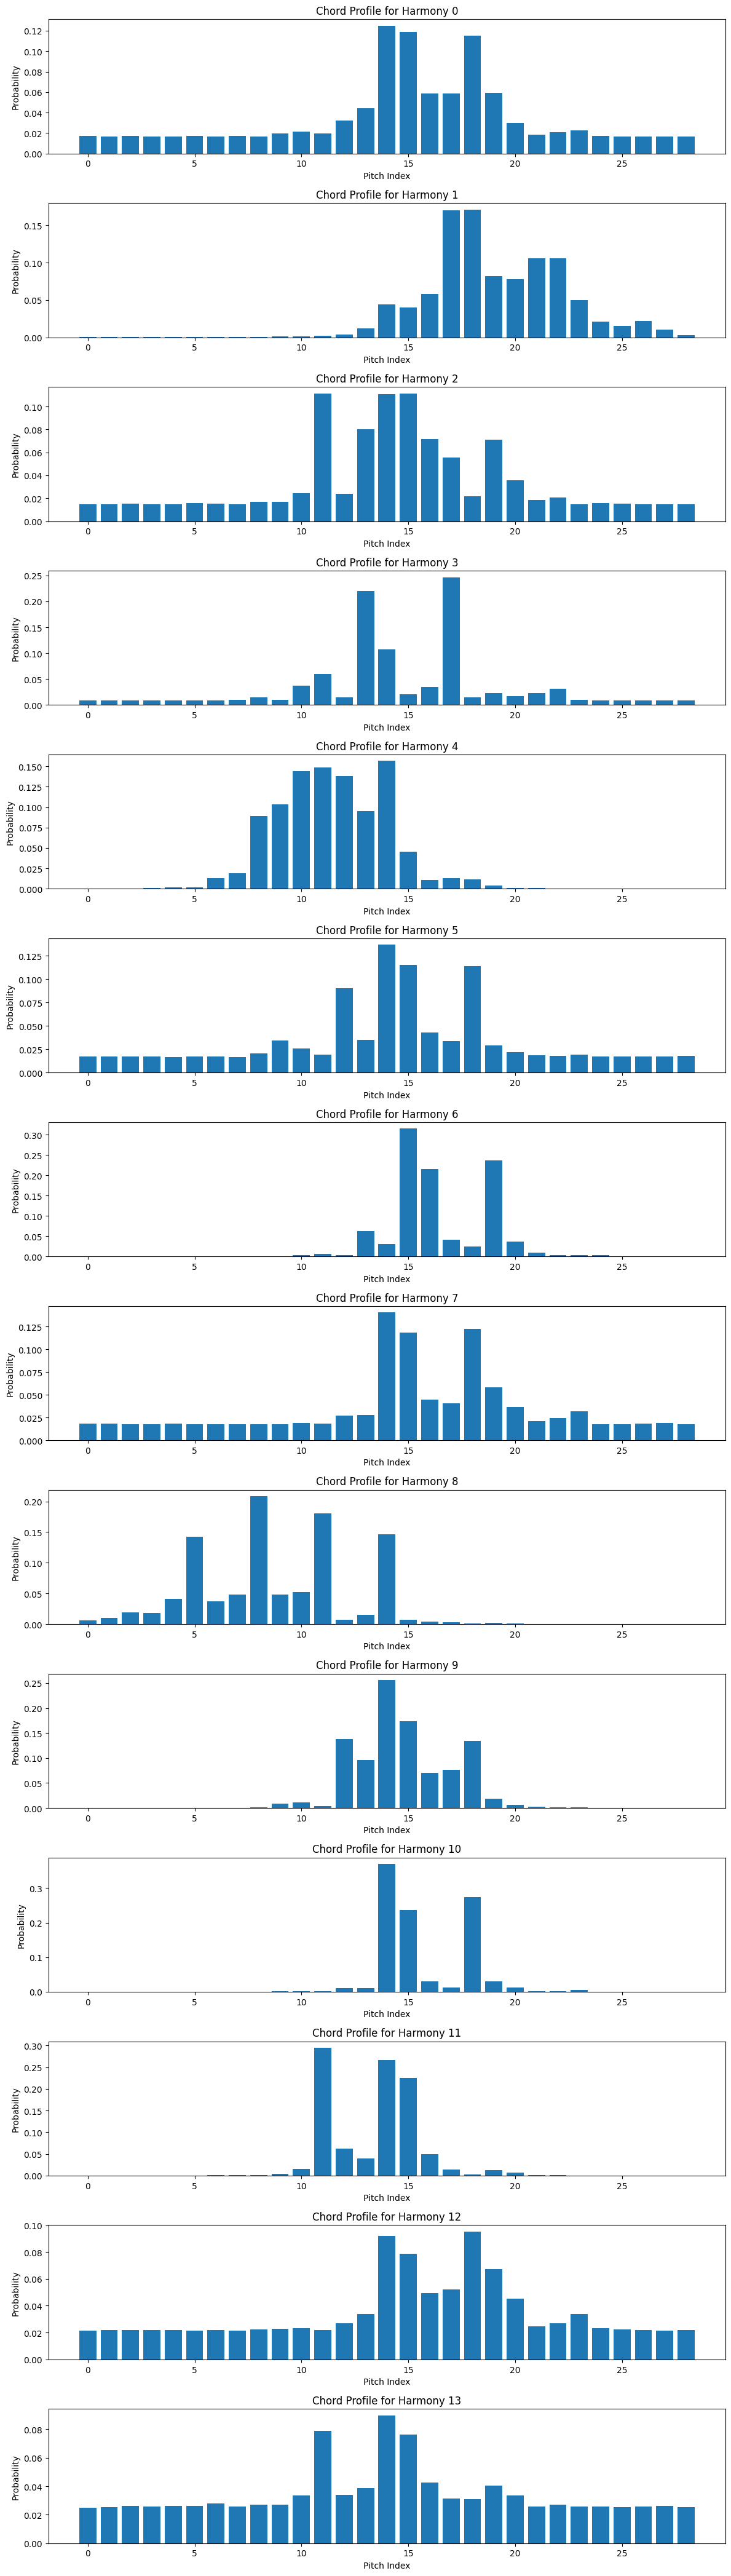

In [24]:
plot_chord_profiles(dcml_params_stage2, len(dcml_chordtypes), npcs, save_as="dcml_chord_profiles")